In [1]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Librerías de modelado
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [13]:
# Cargar dataset
df = pd.read_csv("credit_risk_homeloans.csv")

# Vista rápida
df.head()

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,LP100000,14529,10654,562,180,1,Male,No,0,Graduate,No,Urban,Y
1,LP100001,22885,12859,496,84,0,Male,No,3+,Not Graduate,No,Rural,Y
2,LP100002,4156,10846,310,120,1,Male,Yes,3+,Graduate,Yes,Semiurban,Y
3,LP100003,4285,9311,419,120,1,Male,No,1,Not Graduate,No,Semiurban,Y
4,LP100004,18187,11156,52,360,0,Male,Yes,2,Graduate,No,Rural,N


In [18]:
#Limpienza de la data

# Convertir Loan_Status a binario (Y=1, N=0)
df['Loan_Status'] = df['Loan_Status'].map({'Y':1, 'N':0})

# Reemplazar '3+' por 3 y convertir Dependents a numérico
df['Dependents'] = df['Dependents'].replace('3+', 3)
df['Dependents'] = pd.to_numeric(df['Dependents'], errors='coerce')

# Crear TotalIncome
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']

# Tratar columnas categóricas (encoding con LabelEncoder)
categoricas = ['Gender','Married','Education','Self_Employed','Property_Area']
le = LabelEncoder()
for col in categoricas:
    df[col] = le.fit_transform(df[col].astype(str))

# Verificar dataset transformado
df.head()

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status,TotalIncome
0,LP100000,14529,10654,562,180,1,1,0,0,0,0,2,1,25183
1,LP100001,22885,12859,496,84,0,1,0,3,1,0,0,1,35744
2,LP100002,4156,10846,310,120,1,1,1,3,0,1,1,1,15002
3,LP100003,4285,9311,419,120,1,1,0,1,1,0,1,1,13596
4,LP100004,18187,11156,52,360,0,1,1,2,0,0,0,0,29343


In [17]:
# Revisar valores nulos
df.isnull().sum()

# Revisar nulos
print(df.isnull().sum())

Loan_ID              0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
Property_Area        0
Loan_Status          0
dtype: int64


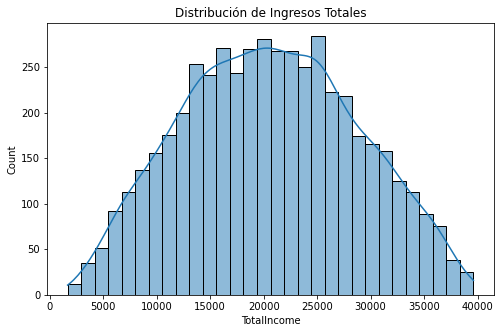

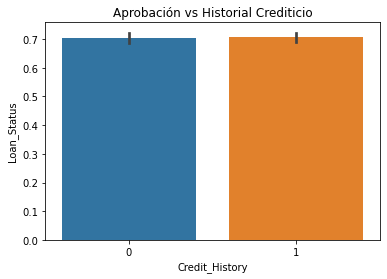

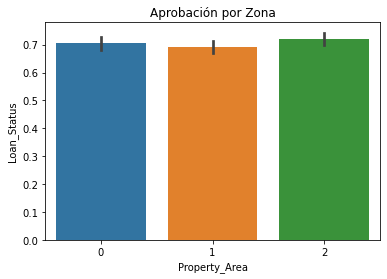

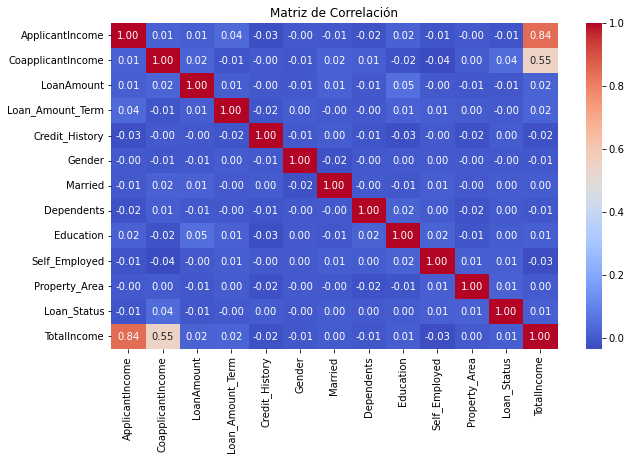

In [19]:
# EDA

# Distribución del ingreso total
plt.figure(figsize=(8,5))
sns.histplot(df['TotalIncome'], kde=True, bins=30)
plt.title("Distribución de Ingresos Totales")
plt.show()

# Relación entre historial crediticio y aprobación
plt.figure(figsize=(6,4))
sns.barplot(x="Credit_History", y="Loan_Status", data=df)
plt.title("Aprobación vs Historial Crediticio")
plt.show()

# Relación entre zona y aprobación
plt.figure(figsize=(6,4))
sns.barplot(x="Property_Area", y="Loan_Status", data=df)
plt.title("Aprobación por Zona")
plt.show()

# Matriz de correlación
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()


In [20]:
#Preparar la data para el modelo

# Features y Target
X = df.drop(['Loan_ID','Loan_Status'], axis=1)
y = df['Loan_Status']

# Estandarización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [23]:
# Modelado
!pip install xgboost

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Modelos
modelos = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Resultados
resultados = {}

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    resultados[nombre] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_pred)
    }

pd.DataFrame(resultados).T


C:\Users\JNCHA\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [13:20:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Accuracy,Precision,Recall,F1,ROC-AUC
Logistic Regression,0.705,0.705000,1.000000,0.826979,0.500000
Random Forest,0.693,0.706861,0.964539,0.815837,0.504303
XGBoost,0.662,0.708286,0.885106,0.786885,0.506960
